In [127]:
import numpy as np
from numpy.random import RandomState
import pandas as pd

from data_loading import load_isoform_and_paralog_y2h_data

from ccsblib import paros_connection

In [167]:
def latest_y2h_data():
    qry = """      select b.large_plate_name,
            retest_pla, retest_pos,
            ad_clone_acc, ad_orf_id,
                db_gene_symbol, db_orf_id,
                    b.manual_score_growth as 3AT,
                            d.manual_score_growth as growth_score_LW_day1,
                    e.manual_score_growth as growth_score_LW_day2
        from tf_screen.final_retest as a
        inner join (select * from iscore.growth_result where large_plate_name like 'TFfnlr07%') as b
        on a.retest_pla = CONVERT(SUBSTRING(b.scoring_pla, -3), SIGNED)
        and a.retest_pos = b.scoring_pos
        
        LEFT join (select * from iscore.growth_result where large_plate_name like 'TFfnlr02%') as d
        on a.retest_pla = CONVERT(SUBSTRING(d.scoring_pla, -3), SIGNED)
        and a.retest_pos = d.scoring_pos
        
            LEFT join (select * from iscore.growth_result where large_plate_name like 'TFfnlr06%') as e
        on a.retest_pla = CONVERT(SUBSTRING(e.scoring_pla, -3), SIGNED)
        and a.retest_pos = e.scoring_pos

        
        where ad_clone_acc is not NULL;"""
    df = pd.read_sql(qry, paros_connection())
    df['plate_is_portrait_orientation'] = df['retest_pla'].map(df.loc[df['ad_clone_acc'] == 'control-1', :].drop_duplicates().set_index('retest_pla')['retest_pos'] != 'H01')
    df = df.loc[~df['ad_clone_acc'].str.startswith('control-'), :]
    df['growth_score_LW_day2'] = df['growth_score_LW_day2'].fillna(df['growth_score_LW_day1'])
    df = (df.drop(columns=['growth_score_LW_day1'])
            .rename(columns={'growth_score_LW_day2': 'LW'}))
    df = df.drop_duplicates()

    old = load_isoform_and_paralog_y2h_data()
    old = old.loc[~old['category'].isin(['rrs_paralogs', 'lit_bm_paralogs']), :]
    df = pd.merge(df,
                  old.loc[:, ['ad_orf_id', 'db_orf_id', 'category']],
                  on=['ad_orf_id', 'db_orf_id'],
                  how='left')
    wrong_cat = (df['category'].notnull() &
             ~df['category'].isin({'lit_bm_isoforms', 'rrs_isoforms'}) &
             ~df['plate_is_portrait_orientation'] &
             (df['retest_pos'].str.slice(0, 1) == 'H'))

    wrong_cat = (wrong_cat | 
                (df['category'].notnull() &
                ~df['category'].isin({'lit_bm_isoforms', 'rrs_isoforms'}) &
                df['plate_is_portrait_orientation'] &
                df['retest_pos'].str.slice(1).isin({'10', '11', '12'}))
                )
    wrong_cat = (wrong_cat | 
                (df['category'].notnull() &
                df['category'].isin({'lit_bm_isoforms', 'rrs_isoforms'}) &
                ~df['plate_is_portrait_orientation'] &
                (df['retest_pos'].str.slice(0, 1) != 'H'))
                )
    wrong_cat = (wrong_cat | 
                (df['category'].notnull() &
                df['category'].isin({'lit_bm_isoforms', 'rrs_isoforms'}) &
                df['plate_is_portrait_orientation'] &
                ~df['retest_pos'].str.slice(1).isin({'10', '11', '12'}))
                )
    df = df.loc[~wrong_cat, :]
    if (df['category'].isnull() & (df['ad_orf_id'] > 0)).sum() > 0:
        raise UserWarning('missing categories')

    if df.duplicated(['retest_pla', 'retest_pos']).any():
        raise UserWarning('Unexpected duplicates')

    def find_empty_ad(row, media):
        if row['category'] not in {'lit_bm_isoforms', 'rrs_isoforms'}:
            matches = df.loc[(df['ad_clone_acc'] == 'empty-AD') &
                            (df['retest_pla'] == row['retest_pla']) &
                            (df['db_orf_id'] == row['db_orf_id']), :]
            if matches.shape[0] > 0:
                vals = set(matches[media].values)
                if len(vals) > 1:
                    matches = df.loc[(df['ad_clone_acc'] == 'empty-AD') &
                                    (df['retest_pla'] == row['retest_pla']) &
                                    (df['retest_pos'].str.slice(1) == row['retest_pos'][1:]) &
                                    (df['retest_pos'] > row['retest_pos']) &
                                    (df['db_orf_id'] == row['db_orf_id']), :]
                    return matches.sort_values('retest_pos')[media].values[0]
                return list(vals)[0]
        else:
            matches = df.loc[(df['ad_clone_acc'] == 'empty-AD') &
                            (df['db_orf_id'] == row['db_orf_id']) &
                            (
                                (~df['plate_is_portrait_orientation'] & (df['retest_pos'].str.slice(0, 1) == 'H')) | 
                                (df['plate_is_portrait_orientation'] & df['retest_pos'].str.slice(1).isin({'10', '11', '12'}))
                            ), :]
            if matches.shape[0] > 0:
                vals = set(matches[media].values)
                if len(vals) > 1:
                    print('error', row['retest_pla', 'retest_pos'])
                return list(vals)[0]


    df['empty_AD_3AT'] = df.loc[df['ad_orf_id'] > 0].apply(find_empty_ad, args=['3AT'], axis=1)
    df['empty_AD_LW'] = df.loc[df['ad_orf_id'] > 0].apply(find_empty_ad, args=['LW'], axis=1)
    df = df.loc[df['ad_orf_id'] > 0, :]

    def score_pair(row):
        if any(row[spot] is None for spot in ['3AT', 'LW', 'empty_AD_3AT', 'empty_AD_LW']):
            return np.nan
        if any(row[spot] == 'NA' for spot in ['3AT', 'LW', 'empty_AD_3AT', 'empty_AD_LW']):
            return np.nan
        score_3at, score_lw, score_empty_ad_3at, score_empty_ad_lw = (int(row[spot]) for spot in ['3AT', 'LW', 'empty_AD_3AT', 'empty_AD_LW'])
        if score_lw < 2 or score_empty_ad_lw < 2:
            return np.nan
        if score_empty_ad_3at == 4:
            return np.nan
        if score_3at <= 1:
            return False
        if (score_3at > score_empty_ad_3at) and (score_3at >= 2):
            return True
        if score_3at <= score_empty_ad_3at:
            return False
        raise UserWarning('Unexpected case:', row)

    df['Y2H_result'] = df.apply(score_pair, axis=1)

    df['ad_gene_symbol'] = df['ad_clone_acc'].apply(lambda x: x[:x.rfind('-')])
    df = df.loc[:, ['large_plate_name',
                    'retest_pla', 
                    'retest_pos',
                    'ad_gene_symbol',
                    'ad_clone_acc',
                    'ad_orf_id',
                    'db_gene_symbol', 
                    'db_orf_id', 
                    'category', 
                    '3AT', 
                    'LW',
                    'empty_AD_3AT',
                    'empty_AD_LW',
                    'Y2H_result']]

    return df

df = latest_y2h_data()
df.head()

,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_acc,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result
0,TFfnlr07_001_002_003_004_005_006,5,A01,ATF2,ATF2-1,101414,ATF2,54731,tf_isoform_ppis,2,4,0,4,True
2,TFfnlr07_001_002_003_004_005_006,5,A02,ATF2,ATF2-1,101414,COL8A1,3053,tf_paralog_ppis,0,4,0,4,False
3,TFfnlr07_001_002_003_004_005_006,5,A03,ATF2,ATF2-1,101414,EFEMP2,2906,tf_paralog_ppis,0,4,0,4,False
4,TFfnlr07_001_002_003_004_005_006,5,A04,ATF2,ATF2-1,101414,FOSL2,12504,tf_isoform_ppis,2,4,0,4,True
5,TFfnlr07_001_002_003_004_005_006,5,A05,ATF2,ATF2-1,101414,JDP2,13624,tf_isoform_ppis,2,4,0,4,True


In [169]:
df.to_csv('../data/internal/Y2H-data_2021-09-03_missing-sequence-confirmation.tsv',
          index=False,
          sep='\t')

In [152]:
df.groupby('category')['Y2H_result'].value_counts()

category             Y2H_result
lit_bm_isoforms      False          237
                     True             1
non_paralog_control  False         1394
                     True            41
paralog_with_PDI     False          403
                     True            13
rrs_isoforms         False          246
                     True             1
tf_isoform_ppis      False         2726
                     True          2607
tf_paralog_ppis      False         2063
                     True           315
Name: Y2H_result, dtype: int64

In [139]:
# something is weird with litbm results
df.loc[(df['category'] == 'lit_bm_isoforms'), :]

,large_plate_name,retest_pla,retest_pos,ad_clone_acc,ad_orf_id,db_gene_symbol,db_orf_id,3AT,LW,plate_is_portrait_orientation,category,empty_AD_3AT,empty_AD_LW,Y2H_result
2,TFfnlr07_001_002_003_004_005_006,5,H09,RXRA-1,100398,PPARD,4144,0,4,False,lit_bm_isoforms,0,4,False
210,TFfnlr07_001_002_003_004_005_006,2,H09,TGIF1-2,100367,CTBP1,6221,0,4,False,lit_bm_isoforms,None,None,NaN
700,TFfnlr07_013_014_015_016_017_018,17,H12,TCF7L2-11,101451,DAXX,52987,0,4,False,lit_bm_isoforms,0,4,False
991,TFfnlr07_013_014_015_016_017_018,18,H07,PAX5-1,100766,DAXX,52987,0,4,False,lit_bm_isoforms,0,4,False
993,TFfnlr07_013_014_015_016_017_018,18,H11,PPARG-4,100340,ZNHIT3,70920,0,4,False,lit_bm_isoforms,0,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12659,TFfnlr07_178_179_180_181_182_183,180,H09,TSC22D1-2,100824,CCDC90B,7368,0,4,False,lit_bm_isoforms,0,4,False
12746,TFfnlr07_178_179_180_181_182_183,182,H10,NR5A2-3,100603,NCOA1,56067,0,4,False,lit_bm_isoforms,None,None,NaN
13170,TFfnlr07_184_185_186_187_188_189,187,H11,STAT1-5,100307,STAT1,4126,0,4,False,lit_bm_isoforms,0,4,False
13255,TFfnlr07_184_185_186_187_188_189,186,H11,LEF1-1,101371,PIAS4,10990,0,4,False,lit_bm_isoforms,0,4,False


In [212]:
# restrict to at least two non-zero isoforms and two PPI partners
# restrict to at least one positive per partner
# only non-zero isoforms

df = df.loc[(df['category'] == 'tf_isoform_ppis'), :]
df = df.loc[df.groupby(['ad_gene_symbol', 'db_orf_id'])['Y2H_result'].transform(lambda x: x.any()), :]
df = df.loc[df.groupby('ad_orf_id')['Y2H_result'].transform(lambda x: x.any()), :]
at_least_two_by_two = (df.groupby(['ad_gene_symbol', 'ad_clone_acc'])
          ['Y2H_result'].apply(lambda x: x.notnull().sum() >= 2)
          .reset_index().groupby('ad_gene_symbol').sum() >= 2)['Y2H_result']
df = df.loc[df['ad_gene_symbol'].map(at_least_two_by_two), :]

,large_plate_name,retest_pla,retest_pos,ad_gene_symbol,ad_clone_acc,ad_orf_id,db_gene_symbol,db_orf_id,category,3AT,LW,empty_AD_3AT,empty_AD_LW,Y2H_result,at_least_2_by_2


In [252]:
random_seeds = [2013670,
                7496427,
                9785871,
                2507712,
                8913313,
                1165330,
                4307586,
                6755760,
                6012226,
                5136785]
sample_size = {'isoform_positives': 300,
               'isoform_negatives': 150,
               'Lit_BM_TF_iso': 250,
               'RRS_TF_iso': 250}
# Tong can add hPRSv2 / hRRSv2
val = pd.DataFrame(columns=['category', 
                            'ad_gene_symbol',
                            'ad_clone_acc',
                            'ad_orf_id',
                            'db_orf_id',
                            'db_gene_symbol'])
output_columns = ['ad_gene_symbol',
                  'ad_clone_acc',
                  'ad_orf_id',
                  'db_orf_id',
                  'db_gene_symbol']

In [256]:
samples = {}
cat = 'isoform_positives'
samples[cat] = (df.loc[df['Y2H_result'] == True,
                            output_columns]
                       .sample(n=sample_size[cat],
                               replace=False,
                               random_state=RandomState(random_seeds.pop(0)))
                       .copy())

In [257]:
cat = 'isoform_negatives'
samples[cat] = (df.loc[df['Y2H_result'] == False,
                            output_columns]
                       .sample(n=sample_size[cat],
                               replace=False,
                               random_state=RandomState(random_seeds.pop(0)))
                       .copy())

In [258]:
seed = random_seeds.pop(0)
rng = RandomState(seed=seed)
neg = pd.DataFrame(columns=output_columns)
sampled_pos_frac = (samples['isoform_positives'].groupby(['ad_gene_symbol', 'db_gene_symbol']).size() / 
                    df.loc[df['Y2H_result'] == True, :].groupby(['ad_gene_symbol', 'db_gene_symbol']).size())
sampled_pos_frac = sampled_pos_frac[sampled_pos_frac.notnull()]
for (ad_gene_symbol, db_gene_symbol), f in sampled_pos_frac.iteritems():
    matches = df.loc[(df['Y2H_result'] == False) &
                     (df['ad_gene_symbol'] == ad_gene_symbol) &
                     (df['db_gene_symbol'] == db_gene_symbol),
                     output_columns]
    if matches.shape[0] == 0:
        continue
    if rng.binomial(n=1, p=f) == 1:
        neg = neg.append(matches.copy())
samples['isoform_matched_negatives'] = neg

In [270]:
clones = pd.read_csv('../data/processed/valid-unique-isoform-clones_2021-07-20.tsv',
                     sep='\t')
vignette_genes = {'ATF2', 'STAT3', 'CREB5', 'MLX', 'PPARG', 'ZSCAN18'}
vignettes = []
for gene_symbol in vignette_genes:
    # get all partners
    partners = df.loc[(df['ad_gene_symbol'] == gene_symbol) &
           ~df['db_gene_symbol'].str.startswith('KRTAP'),
           ['db_orf_id', 'db_gene_symbol']].drop_duplicates()
    for _i, row in partners.iterrows():
        for clone_acc in clones.loc[clones['gene'] == gene_symbol, 'clone_acc'].unique():
            vignettes.append((gene_symbol, clone_acc, np.nan, row['db_orf_id'], row['db_gene_symbol']))

samples['whole_tf_genes'] = pd.DataFrame(columns=output_columns, data=vignettes)

In [275]:
val = (pd.concat(samples)
         .reset_index(level=0)
         .rename(columns={'level_0': 'category'})
         .reset_index(drop=True))

In [276]:
print(val.shape[0], val[output_columns].drop_duplicates().shape[0])

749 729


In [277]:
print(val['ad_orf_id'].nunique(),
      val['db_orf_id'].nunique())

117 309


In [278]:
val['category'].value_counts()

isoform_positives            300
isoform_matched_negatives    164
isoform_negatives            150
whole_tf_genes               135
Name: category, dtype: int64

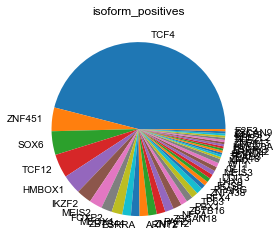

In [241]:
from matplotlib import pyplot as plt
val.loc[val['category'] == 'isoform_positives', 'ad_gene_symbol'].value_counts().plot.pie()
plt.ylabel('')
plt.title('isoform_positives')
plt.savefig('../figures/N2H-validation_isoform-positives-by-gene_pie.pdf',
            bbox_inches='tight')

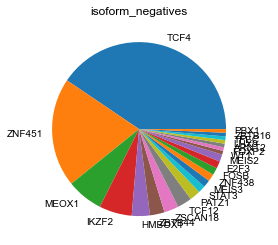

In [243]:
val.loc[val['category'] == 'isoform_matched_negatives', 'ad_gene_symbol'].value_counts().plot.pie()
plt.ylabel('')
plt.title('isoform_negatives')
plt.savefig('../figures/N2H-validation_isoform-negatives-by-gene_pie.pdf',
            bbox_inches='tight')

In [251]:
val.head()

,category,ad_gene_symbol,ad_clone_acc,ad_orf_id,db_orf_id,db_gene_symbol
0,isoform_positives,TCF4,TCF4-5,100703,7646,LENG1
1,isoform_positives,ZBTB16,ZBTB16-1,101025,13770,ZNF79
2,isoform_positives,SOX6,SOX6-6,100009,71402,PIBF1
3,isoform_positives,ZBTB44,ZBTB44-3,101276,6195,TCEA2
4,isoform_positives,STAT3,STAT3-1,101222,842,BMX


In [279]:
val.to_csv('../output/N2H_pairs_missing_controls.tsv',
            index=False,
           sep='\t')